In [1]:
import mdtraj as md
import MDAnalysis as mda
import numpy as np
from scipy.stats import ttest_ind_from_stats

from tqdm import tqdm
from pathlib import Path
import os
from natsort import natsorted
import pandas as pd
from addict import Dict as Adict

import pyemma as pm
import deeptime as dt
import deeptime.markov.msm as msm
import deeptime.markov.hmm as hmm

from deeptime.plots import plot_implied_timescales, plot_energy2d, plot_contour2d_from_xyz, plot_flux
from deeptime.markov.sample import *
from deeptime.markov import TransitionCountEstimator
from deeptime.util import energy2d

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from funcs_build_msm import _tica, _kmeans, get_data 
from funcs_validate_msm import *
from funcs_sample import *
from funcs_plotting import *
from funcs_characterise import *
from paths import *

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
study_name = 'markov_lag'
data_path = Path(f'data_egfr/msm/{study_name}')
summary_f = data_path/f'{study_name}.h5'
hps = pd.read_hdf(summary_f, key='hps')
raw = pd.read_hdf(summary_f, key='result_raw')

In [13]:
n_score = 20
columns = [f't{i+2}' for i in range(n_score)] \
        + [f'gap_{i+2}' for i in range(n_score)] \
        + [f'vamp2eq_{i+2}' for i in range(n_score)]

In [24]:
markov_lags = hps['markov__lag'].to_list()

In [25]:
summary = raw.replace([np.inf, -np.inf], np.nan)
summary.dropna(inplace=True)
summary_groupby = summary.groupby('hp_id')[columns].agg(['mean', 'std'])
summary_groupby

t2                          t3                          t4  \
               mean           std          mean           std          mean   
hp_id                                                                         
0      1.127418e+05  9.310521e+04  1.572426e+04  8.885414e+03  6.149926e+03   
1      3.429490e+05  2.889728e+05  5.526598e+04  2.481599e+04  2.450485e+04   
2      7.944679e+05  5.835716e+05  8.056479e+04  3.366750e+04  3.912286e+04   
3      3.779698e+06  3.012892e+06  3.024130e+05  1.451146e+05  1.310679e+05   
4      6.785102e+06  5.788157e+06  6.535352e+05  3.197599e+05  2.506655e+05   
5      3.107623e+07  2.905237e+07  3.078645e+06  1.418626e+06  1.191364e+06   

                                 t5                            t6  \
                 std           mean            std           mean   
hp_id                                                               
0        3557.756368    2154.955521     657.087676    1728.004970   
1       12655.616636    7585.068315    1680.292851    6337.817896   
2       23258.203482   12569.278109    2180.763809   10532.761478   
3       70363.005822   46954.615222   19819.981047   33030.161074   
4      124506.742566   73741.630079   18147.446874   53766.503795   
5      615387.989536  379766.309704  158194.763659  260873.398720   

                     ... vamp2eq_17           vamp2eq_18           vamp2eq_19  \
                std  ...       mean       std       mean       std       mean   
hp_id                ...                                                        
0        576.408360  ...  16.957995  0.004921  17.951594  0.005898  18.944720   
1       1589.142732  ...  16.938946  0.009669  17.929911  0.011591  18.920167   
2       2778.623328  ...  16.929800  0.006136  17.919732  0.007694  18.908988   
3       7760.208265  ...  16.881901  0.009138  17.865283  0.011861  18.846801   
4      12672.823753  ...  16.853197  0.018899  17.832379  0.022015  18.808926   
5      55955.237798  ...  16.844296  0.021306  17.821525  0.025431  18.796579   

                vamp2eq_20           vamp2eq_21            
            std       mean       std       mean       std  
hp_id                                                      
0      0.006775  19.937437  0.007882  20.929385  0.008851  
1      0.013742  19.909524  0.016127  20.898091  0.018973  
2      0.009677  19.897393  0.011686  20.885003  0.013946  
3      0.014806  19.827561  0.018035  20.806548  0.021682  
4      0.026250  19.784142  0.030677  20.757802  0.035436  
5      0.030388  19.769877  0.035755  20.741103  0.040100  

[6 rows x 120 columns]

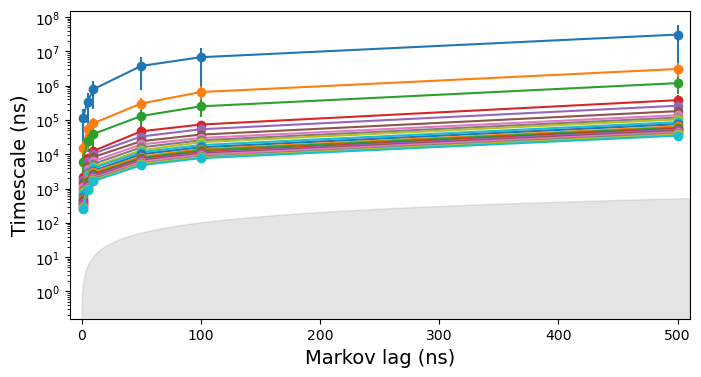

In [48]:
fig, ax = plt.subplots(figsize=(8, 4))

for i in range(n_score):
    ax.errorbar(markov_lags, summary_groupby[f't{i+2}']['mean'].to_list(), 
                yerr=summary_groupby[f't{i+2}']['std'].to_list(), 
                marker='o', 
                label='t2')

ax.fill_between(np.linspace(-10,510,1000), y1=np.linspace(-10,510,1000), color='gray', alpha=0.2)
ax.set_xlim([-10, 510])
ax.set_yscale('log')
ax.set_xlabel('Markov lag (ns)', fontsize=14)
ax.set_ylabel('Timescale (ns)', fontsize=14)

plt.show()

In [39]:
ax.get_xlim()

(-51.39500000000001, 552.3950000000001)

In [ ]:
y1=ax.get_xlim()